In [2]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import tensorflow as tf
from tensorflow import keras
import os

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import random
from tensorflow.keras.preprocessing.image import load_img

2023-08-01 12:57:06.659244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 12:57:07.759261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
IMAGE_SIZE = [224, 224]
weight_size = 224
height_size = 224
batch_size = 32

In [4]:
train_path = './data/train/'
valid_path = './data/valid/'
test_path = './data/test/'

### Data Exploration

In [5]:
# Get a list of classes (groups) in your dataset
classes = [class_name for class_name in sorted(os.listdir(train_path)) if not class_name.startswith('.')]
print("Classes:", classes)

Classes: ['kick', 'punch']


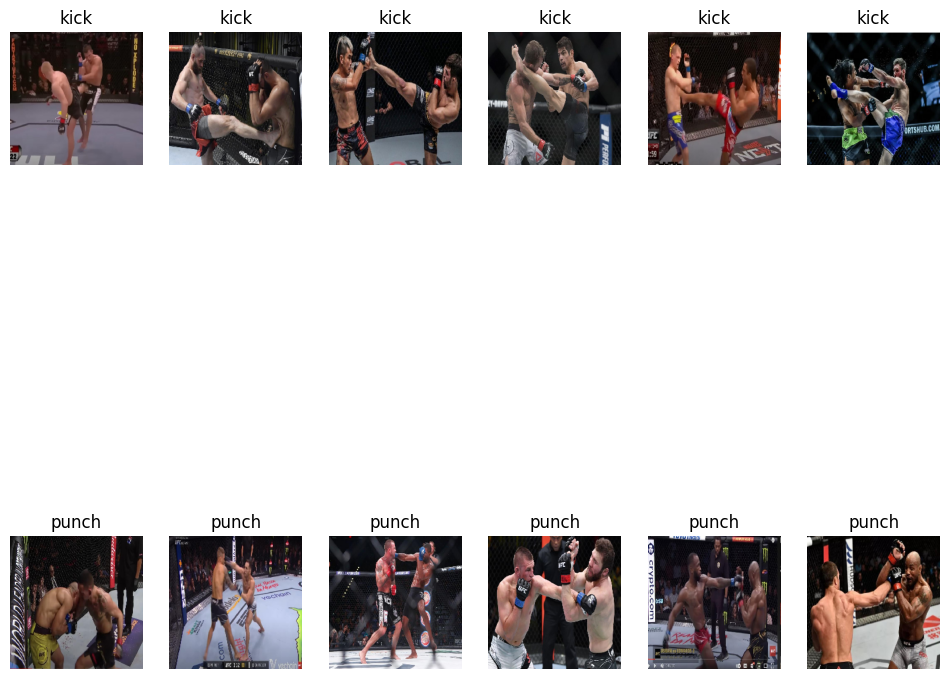

In [6]:
# Number of samples per class to display
num_samples_per_class = 6

# Function to display sample images from each class
def show_sample_images(data_dir, classes, num_samples_per_class):
    plt.figure(figsize=(12,12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = random.sample(os.listdir(class_dir), num_samples_per_class)

        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(weight_size, height_size))

            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Call the function to show sample images from each class
show_sample_images(train_path, classes, num_samples_per_class)


In [7]:
folders = glob('data/train/*')

In [8]:
len(folders)

2

In [8]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)

2023-08-01 11:12:26.447920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-01 11:12:26.478736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-01 11:12:26.478920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0,1]
    rotation_range=90,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.4,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.4,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.5,             # Apply shear transformation
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Use the nearest pixel to fill missing areas after augmentation
)

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 409 images belonging to 2 classes.


In [13]:
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 60 images belonging to 2 classes.


In [14]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 128 images belonging to 2 classes.


### Displaying the augmentation of the images

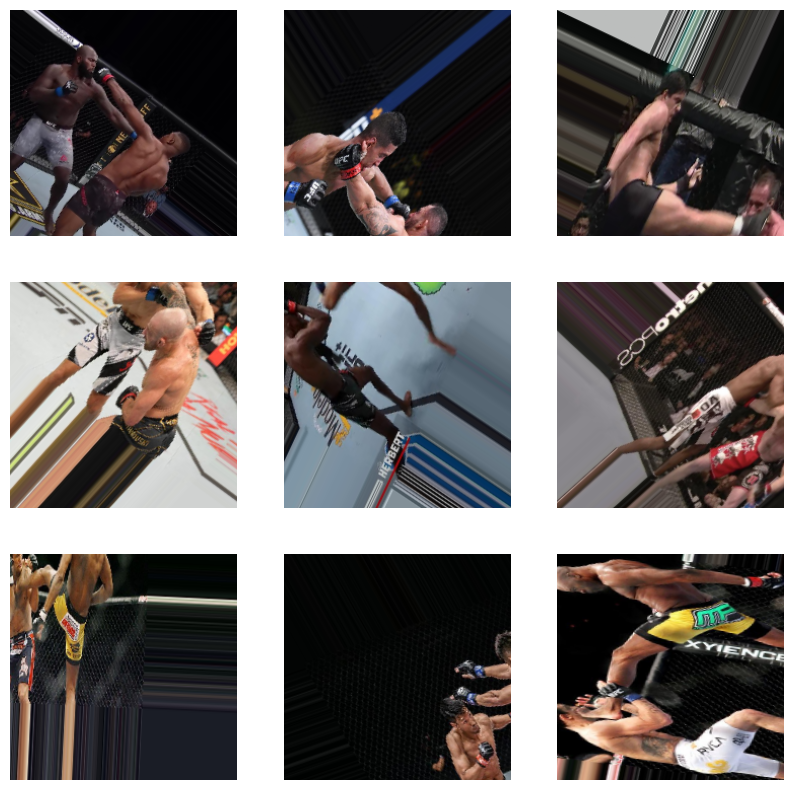

In [16]:
plt.figure(figsize=(10, 10))
images, _ = next(training_set)
for i, image in enumerate(images[: 9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [21]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_just_vgg.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = vgg_model.fit(
    training_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks)

Epoch 1/50


2023-08-01 11:16:25.210833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.4866

2023-08-01 11:16:28.884389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 4s 286ms/step - loss: 0.9074 - accuracy: 0.4866 - val_loss: 0.7071 - val_accuracy: 0.4922
Epoch 2/50
13/13 [==============================] - 4s 281ms/step - loss: 0.8444 - accuracy: 0.4939 - val_loss: 0.6960 - val_accuracy: 0.5781
Epoch 3/50
13/13 [==============================] - 4s 298ms/step - loss: 0.7957 - accuracy: 0.5428 - val_loss: 0.6892 - val_accuracy: 0.5391
Epoch 4/50
13/13 [==============================] - 4s 287ms/step - loss: 0.7679 - accuracy: 0.5526 - val_loss: 0.6980 - val_accuracy: 0.5391
Epoch 5/50
13/13 [==============================] - 4s 289ms/step - loss: 0.8217 - accuracy: 0.5330 - val_loss: 0.6794 - val_accuracy: 0.6094
Epoch 6/50
13/13 [==============================] - 4s 311ms/step - loss: 0.8299 - accuracy: 0.5306 - val_loss: 0.6691 - val_accuracy: 0.6250
Epoch 7/50
13/13 [==============================] - 4s 290ms/step - loss: 0.7771 - accuracy: 0.5526 - val_loss: 0.6621 - val_accuracy: 0.5781
Epoch 8/50
13/13 

In [23]:
test_model = keras.models.load_model(
    "./models/convnet_with_just_vgg.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-08-01 11:20:21.574189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 98ms/step - loss: 0.6331 - accuracy: 0.6333
Test accuracy: 0.633


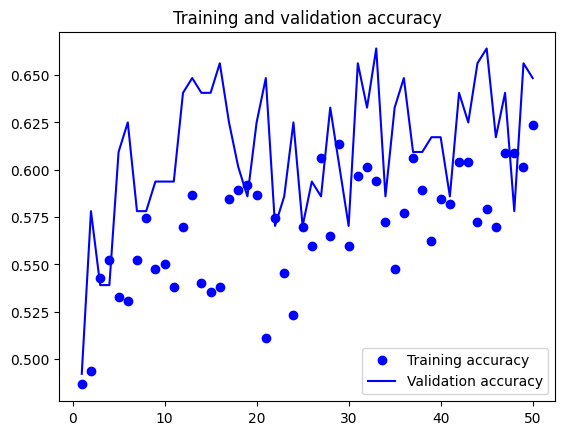

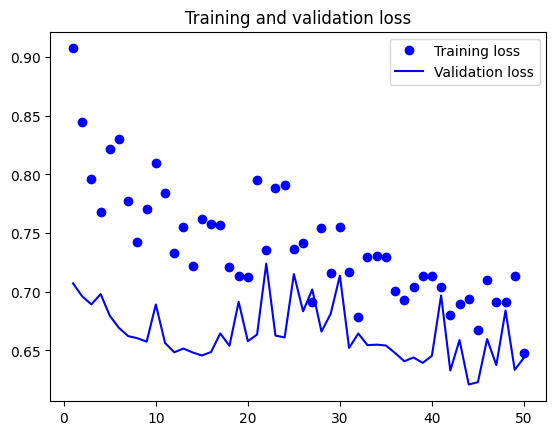

In [24]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Resnet50

In [25]:
from keras.applications.resnet_v2 import ResNet50V2

In [26]:
resnet = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)
resnet_model = Model(inputs=resnet.input, outputs=prediction)

In [27]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [28]:
resnet_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_resnet.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = resnet_model.fit(
    training_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks)

Epoch 1/50


2023-08-01 11:35:52.933777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 1.7426 - accuracy: 0.4597

2023-08-01 11:35:58.460554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 7s 325ms/step - loss: 1.7426 - accuracy: 0.4597 - val_loss: 1.3666 - val_accuracy: 0.5234
Epoch 2/50
13/13 [==============================] - 3s 267ms/step - loss: 1.6039 - accuracy: 0.5183 - val_loss: 1.3392 - val_accuracy: 0.5078
Epoch 3/50
13/13 [==============================] - 4s 296ms/step - loss: 1.4925 - accuracy: 0.5061 - val_loss: 1.3258 - val_accuracy: 0.5156
Epoch 4/50
13/13 [==============================] - 3s 265ms/step - loss: 1.4992 - accuracy: 0.5403 - val_loss: 1.3244 - val_accuracy: 0.5312
Epoch 5/50
13/13 [==============================] - 4s 288ms/step - loss: 1.3042 - accuracy: 0.5623 - val_loss: 1.3011 - val_accuracy: 0.5391
Epoch 6/50
13/13 [==============================] - 4s 276ms/step - loss: 1.4009 - accuracy: 0.5257 - val_loss: 1.2939 - val_accuracy: 0.5469
Epoch 7/50
13/13 [==============================] - 3s 262ms/step - loss: 1.3416 - accuracy: 0.5232 - val_loss: 1.2951 - val_accuracy: 0.5547
Epoch 8/50
13/13 

In [30]:
test_model = keras.models.load_model(
    "./models/convnet_with_resnet.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-08-01 11:46:05.944602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 1s 555ms/step - loss: 1.1269 - accuracy: 0.5667
Test accuracy: 0.567


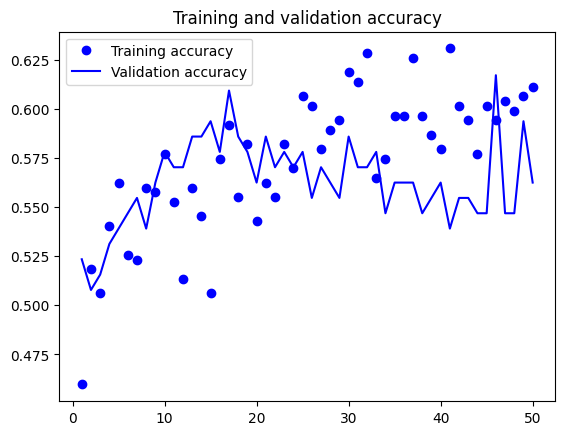

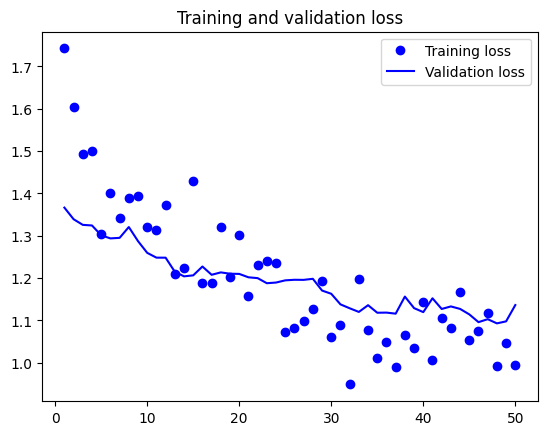

In [31]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### InceptionResNetV2

In [32]:
from keras.applications import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D

In [33]:
inception = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in inception.layers:
    layer.trainable = False
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

inception_model = Model(inputs=inception.input, outputs=predictions)

In [34]:
inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [35]:
inception_training_set = train_datagen.flow_from_directory(train_path,
                                                           target_size=(299, 299),
                                                           batch_size=batch_size,
                                                           class_mode='categorical')

Found 409 images belonging to 2 classes.


In [43]:
inception_valid_set = valid_datagen.flow_from_directory(valid_path,
                                                      target_size=(299, 299),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

Found 128 images belonging to 2 classes.


In [36]:
inception_test_set = test_datagen.flow_from_directory(test_path,
                                                      target_size=(299, 299),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

Found 60 images belonging to 2 classes.


In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
inception_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_inceptionResnet.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = inception_model.fit(
    inception_training_set,
    steps_per_epoch=409//32,
    epochs=100,
    validation_data=inception_valid_set,
    callbacks=callbacks,
    validation_steps=128//32)

Epoch 1/100


2023-08-01 12:45:07.165192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.5252

2023-08-01 12:45:11.860143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 6s 525ms/step - loss: 0.7762 - accuracy: 0.5252 - val_loss: 0.6473 - val_accuracy: 0.6484
Epoch 2/100
12/12 [==============================] - 6s 544ms/step - loss: 0.7765 - accuracy: 0.5093 - val_loss: 0.6464 - val_accuracy: 0.6562
Epoch 3/100
12/12 [==============================] - 7s 612ms/step - loss: 0.8115 - accuracy: 0.5078 - val_loss: 0.6459 - val_accuracy: 0.6797
Epoch 4/100
12/12 [==============================] - 7s 540ms/step - loss: 0.8191 - accuracy: 0.4960 - val_loss: 0.6452 - val_accuracy: 0.6875
Epoch 5/100
12/12 [==============================] - 6s 531ms/step - loss: 0.7790 - accuracy: 0.5517 - val_loss: 0.6447 - val_accuracy: 0.6875
Epoch 6/100
12/12 [==============================] - 7s 553ms/step - loss: 0.7726 - accuracy: 0.5332 - val_loss: 0.6444 - val_accuracy: 0.6797
Epoch 7/100
12/12 [==============================] - 7s 549ms/step - loss: 0.7988 - accuracy: 0.5119 - val_loss: 0.6440 - val_accuracy: 0.6641
Epoch 8/100

In [40]:
test_model = keras.models.load_model(
    "./models/convnet_with_inceptionResnet.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-08-01 12:29:18.248080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 3s 1s/step - loss: 0.6795 - accuracy: 0.6000
Test accuracy: 0.600


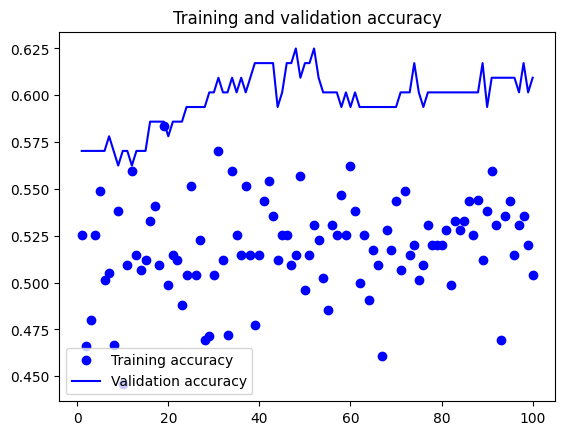

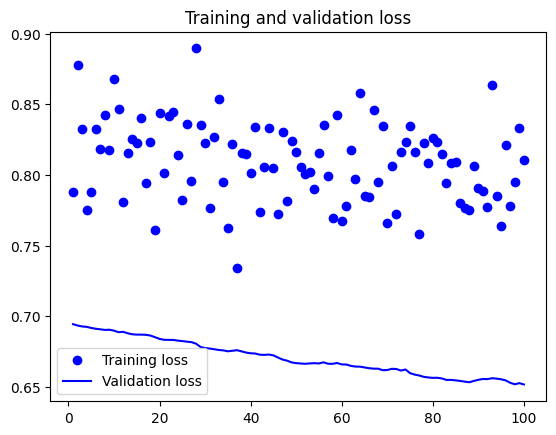

In [41]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_inceptionResnet_first_dataset.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = inception_model.fit(
    training_set,
    steps_per_epoch=409//32,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks,
    validation_steps=128//32)

Epoch 1/50


2023-08-01 12:40:21.362769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - ETA: 0s - loss: 1.0259 - accuracy: 0.5225

2023-08-01 12:40:25.404941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 6s 370ms/step - loss: 1.0259 - accuracy: 0.5225 - val_loss: 0.6512 - val_accuracy: 0.6172
Epoch 2/50
12/12 [==============================] - 4s 340ms/step - loss: 1.0577 - accuracy: 0.5279 - val_loss: 0.6508 - val_accuracy: 0.6172
Epoch 3/50
12/12 [==============================] - 4s 347ms/step - loss: 1.1013 - accuracy: 0.5279 - val_loss: 0.6480 - val_accuracy: 0.6172
Epoch 4/50
12/12 [==============================] - 4s 341ms/step - loss: 1.0249 - accuracy: 0.5517 - val_loss: 0.6478 - val_accuracy: 0.6172
Epoch 5/50
12/12 [==============================] - 4s 373ms/step - loss: 1.0394 - accuracy: 0.5305 - val_loss: 0.6472 - val_accuracy: 0.6172
Epoch 6/50
12/12 [==============================] - 4s 348ms/step - loss: 1.0590 - accuracy: 0.5225 - val_loss: 0.6462 - val_accuracy: 0.6250
Epoch 7/50
12/12 [==============================] - 4s 353ms/step - loss: 0.9629 - accuracy: 0.5358 - val_loss: 0.6455 - val_accuracy: 0.6250
Epoch 8/50
12/12 

In [15]:
test_model = keras.models.load_model(
    "./models/convnet_with_inceptionResnet_first_dataset.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-08-01 12:57:39.673253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-01 12:57:39.736976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-01 12:57:39.737159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2/2 [==============================] - 7s 1s/step - loss: 0.6880 - accuracy: 0.6833
Test accuracy: 0.683


## YoloV8

In [17]:
from ultralytics import YOLO

In [18]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

In [19]:

# Train the model
model.train(data='/home/jorgeluisg/Documents/001_George_brown/DL_2/project/data', epochs=20, imgsz=64)

Ultralytics YOLOv8.0.145 🚀 Python-3.9.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/home/jorgeluisg/Documents/001_George_brown/DL_2/project/data, epochs=20, patience=50, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=t

In [20]:
import PIL

ValueError: Could not save to JPEG for display

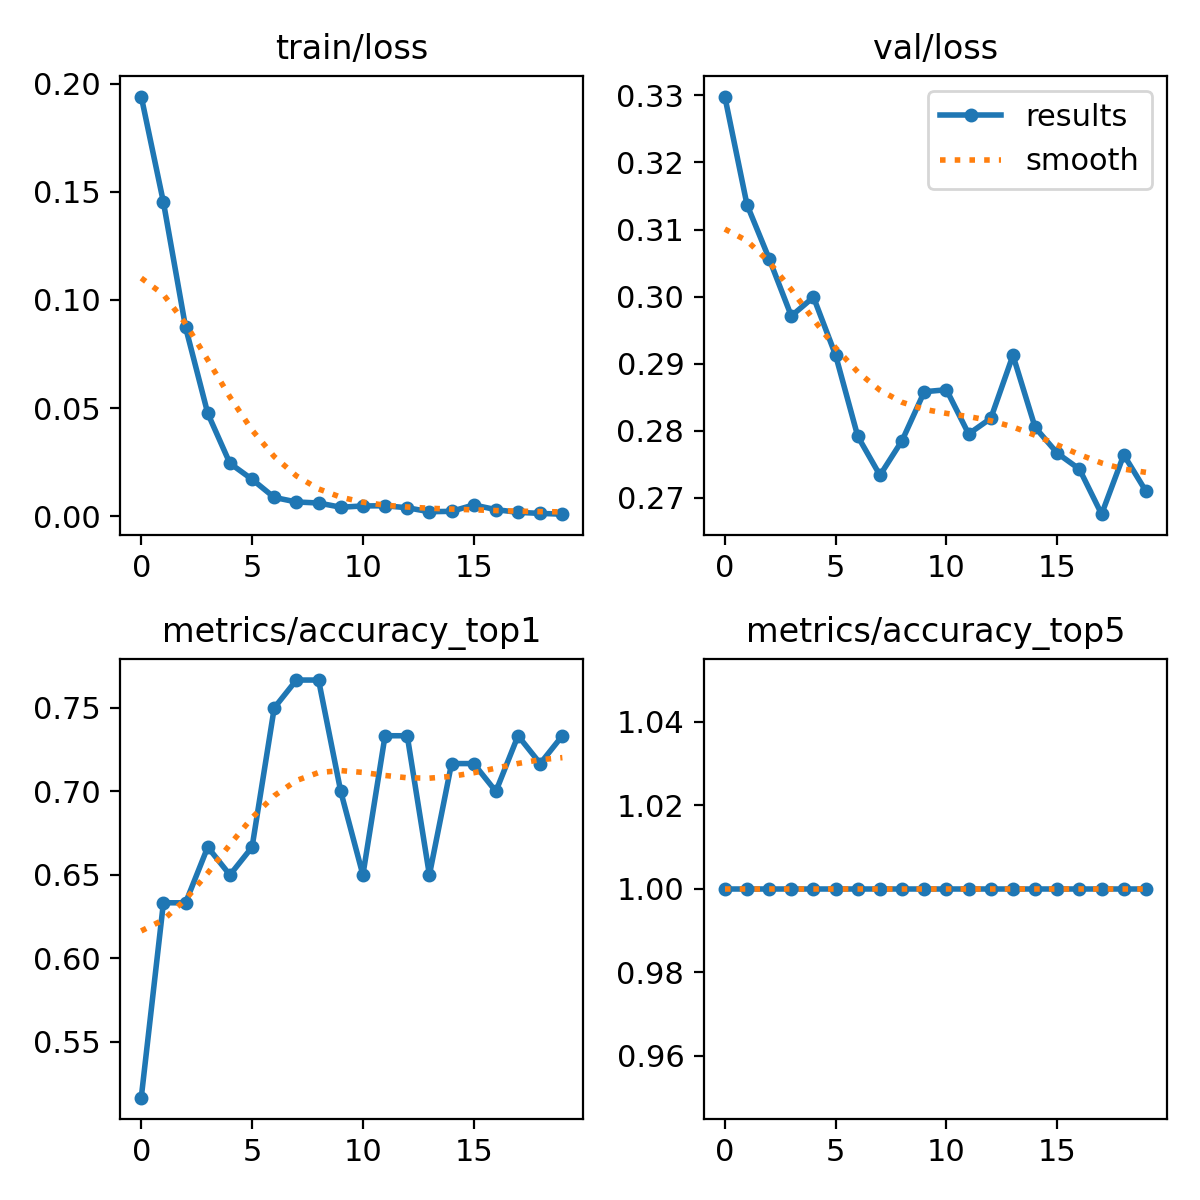

In [25]:
PIL.Image.open('/home/jorgeluisg/Documents/001_George_brown/DL_2/project/runs/classify/train7/results.png')

In [26]:
predict = YOLO('/home/jorgeluisg/Documents/001_George_brown/DL_2/project/runs/classify/train7/weights/best.pt')  # load a custom model

source = '/home/jorgeluisg/Documents/001_George_brown/DL_2/project/data/test/punch/Holm-vs-Aldana-1024x682_jpg.rf.09bae4f158e1f8cbb74a4047dbdafe5b.jpg'  # file/folder, 0 for webcam

In [27]:
# Predict with the model
results = predict(source)  # predict on an image


image 1/1 /home/jorgeluisg/Documents/001_George_brown/DL_2/project/data/test/punch/Holm-vs-Aldana-1024x682_jpg.rf.09bae4f158e1f8cbb74a4047dbdafe5b.jpg: 64x64 punch 0.73, kick 0.27, 2.4ms
Speed: 1.0ms preprocess, 2.4ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)


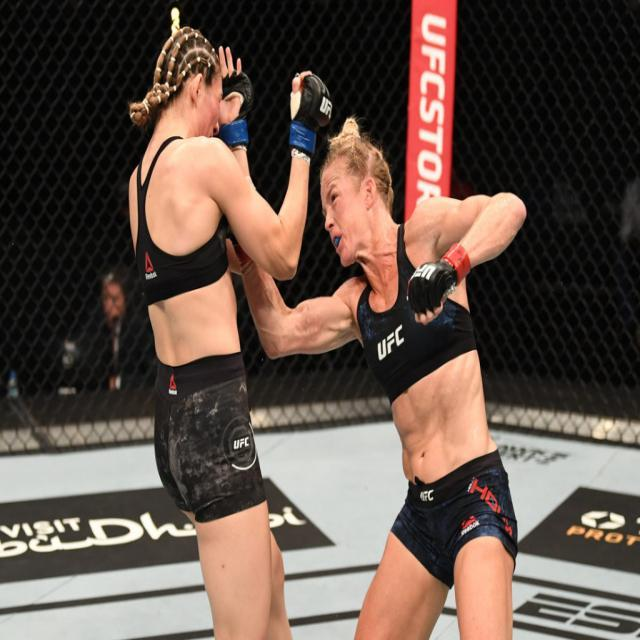

In [28]:
PIL.Image.open(source)

### With YoloV8 we got a better performance of the model